<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/sensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum Sensing with Conjugate Pairs $\rho \otimes \rho*$**

<font color="blue"> *Bell Simulation and Scaling Analysis*

**Exponential learning advantages with conjugate states and minimal quantum memory** [arXiv:2403.03469](https://arxiv.org/abs/2403.03469)
* Proposes a resource-joint measurements on a state and its complex conjugate $\rho \otimes \rho^{*}$ * with an exponential advantage in sample complexity for learning displacement amplitudes $y_{q,p} = \text{Tr}(D_{q,p} \rho)$. Two steps process for magnitude and sign learning:
* First, **non-adaptive magnitude learning** efficiently estimates $|y_{q,p}|^2$ with sample complexity of $(\log d / \epsilon^4)$, Theorem 2 (exponentially better than $\Omega(\sqrt{d})$ measurements required without conjugate pair, Theorem 1).
* Second, **adaptive sign learning** to resolve the sign/phase, also with logarithmic sample complexity (Theorem 5)

DIAGNOSIS FOR INJECTED SIGNAL
for (q,p) = (3, 5) on 11 sensors with 200 shots and 0.9 signal strength ε
Recovered peak from Bell measurement:  (q*, p*) = (3, 5)
Ground truth peak from Tr(D ρ_signal):   (q, p) = (3, 5)
Ground truth peak from Tr(D signal):     (q, p) = (3, 5)
----------------------------------------------------------------------
Peaks at `(q_0, p_0)` and `(-q_0, -p_0) mod d` in displacement map:
  At injected (q₀,p₀)          = (3,5): 0.26359093792011040191525240
  At symmetric (-q₀,-p₀) mod d = (8,6): 0.26359093792011040191525240
Final decision: (3, 5)
----------------------------------------------------------------------


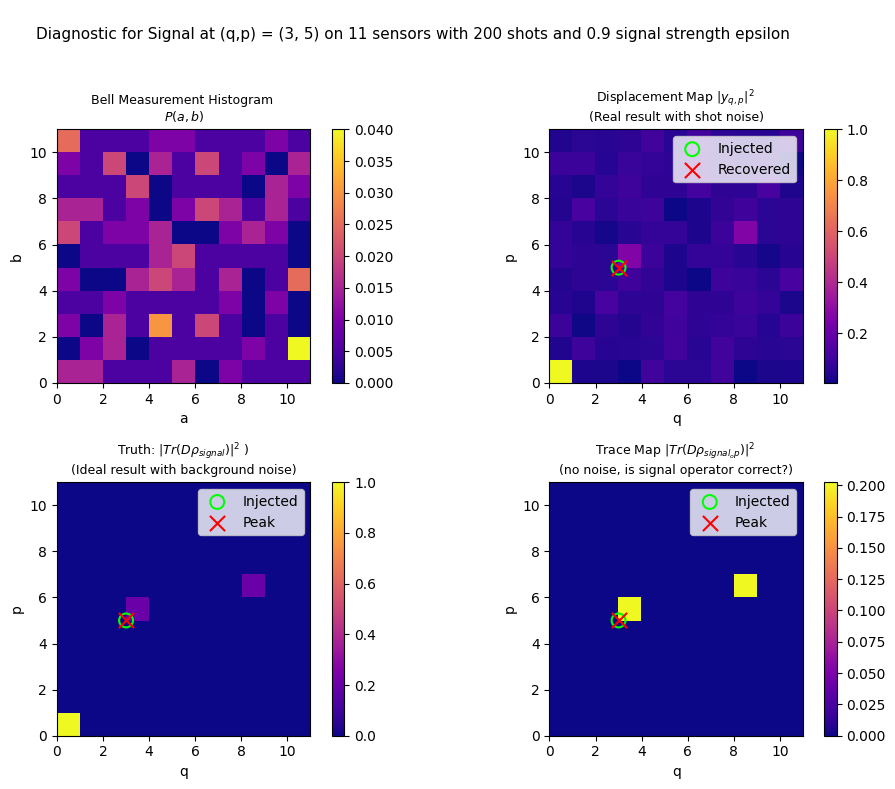

In [ ]:
# @title Diagnosis for Bell Protocol

# (Displacement map of Bell Measurement on Conjugate Pairs)
import numpy as np
import matplotlib.pyplot as plt

import random
#seed_value = 42
#random.seed(seed_value)

# Quantum sensor array for photon localization in phase space (creates states and displacement operators)
class QuantumSensorArray:
    def __init__(self, n_sensors, array_length=1.0):
        self.n_sensors = n_sensors
        self.L = array_length
        self.dim = n_sensors  # Hilbert space dimension

    # Constructs the Heisenberg-Weyl displacement operator D_{q,p} = τ^{qp} Z^p X^q
    def get_displacement_operator(self, q_idx, p_idx):
        d = self.dim
        omega = np.exp(2j * np.pi / d)
        Z = np.diag([omega ** j for j in range(d)])
        X = np.roll(np.eye(d), 1, axis=0)
        tau = np.exp(np.pi * 1j * (d + 1) / d)
        D_qp = tau ** (q_idx * p_idx) * np.linalg.matrix_power(Z, p_idx) @ np.linalg.matrix_power(X, q_idx)
        return D_qp

# Constructs Bell basis |Φ_{a,b}> which is eigenbasis for D_{q,p} ⊗ D_{-q,p}. |Φ_{a,b}> = (1/√d) Σ_j exp(2πi*b*j/d) |j+a> ⊗ |-j>
def construct_bell_basis(sensor_array):
    d = sensor_array.dim
    bell_states = []
    for a in range(d):
        for b in range(d):
            state = np.zeros(d * d, dtype=complex)
            for j in range(d):
                phase = np.exp(2j * np.pi * b * j / d)
                ket1_idx = (j + a) % d
                ket2_idx = (-j + d) % d  # Use +d to ensure positive result before modulo
                final_idx = ket1_idx * d + ket2_idx
                state[final_idx] += phase
            state /= np.sqrt(d) # Normalize
            bell_states.append(state)
    return np.array(bell_states).T

# Simulates measurements of rho_tensor in Bell basis with projectors (outer product): bell_state @ bell_state.conj().T
def simulate_bell_measurements(rho_tensor, d, sensor_array, n_shots=1000):
    bell_basis = construct_bell_basis(sensor_array)
    projectors = []
    for i in range(d * d):
        bell_state = bell_basis[:, i:i+1]
        projector = bell_state @ bell_state.conj().T
        projectors.append(projector)

    # Theoretical probabilities calculated inside simulate_bell_measurements according to Born rule: $p_{a,b} = \text{Tr}[\Pi_{a,b} (\rho \otimes \rho^*)]$
    probs = [np.real(np.trace(p @ rho_tensor)) for p in projectors]
    probs = np.maximum(0, probs)
    probs /= np.sum(probs)

    outcomes = np.random.choice(d * d, size=n_shots, p=probs)
    a_vals = outcomes // d
    b_vals = outcomes % d
    return a_vals, b_vals

# Fourier kernel (character) $e^{i \frac{2\pi}{d} (a p - b q)}$</font> = $\chi_{q,p}(a,b)$
# to reconstruct displacement map |y_{q,p}|^2 from Bell measurement outcomes p_{a,b}
# Estimator v_qp is for y_{q,p}^2. The map shows |v_qp| which is |y_{q,p}|^2
def compute_displacement_map(p_ab, d):
    v_qp = np.zeros((d, d), dtype=complex)
    a_coords = np.arange(d)
    b_coords = np.arange(d)

    for q in range(d):
        for p in range(d):
            phase_grid = np.exp(2j * np.pi * (a_coords[:, np.newaxis] * p - b_coords * q) / d)
            v_qp[q, p] = np.sum(p_ab * phase_grid)

    return np.abs(v_qp)

# Special: Computes 'ground truth' displacement map |y_{q,p}|^2 by directly calculating y_{q,p} = Tr(D_{q,p} ρ)
def compute_yqp_via_trace(rho, sensor_array):
    d = sensor_array.dim
    y_qp = np.zeros((d, d), dtype=complex)
    for q in range(d):
        for p in range(d):
            D = sensor_array.get_displacement_operator(q, p)
            y_qp[q, p] = np.trace(D @ rho)
    return np.abs(y_qp) ** 2

# Runs test for a given signal displacement (q_0, p_0).
def test_bell_on_pure_signal(sensor_array, q_0, p_0, epsilon=0.4, n_shots=1000):
    d = sensor_array.dim

    # Step 1: Construct unknown signal state ρ_signal: To create a signal peak at (q₀,p₀) in the displacement basis,
    # the state ρ = (1/d)(I + ε * signal_op) is constructed, where signal_op is Hermitian.
    D_qp_0 = sensor_array.get_displacement_operator(q_0, p_0)
    signal_operator = 0.5 * (D_qp_0.conj().T + D_qp_0)  # The signal is on the D† component of Bloch decomposition
    rho_signal = (1/d) * (np.eye(d) + epsilon * signal_operator)

    # The "pure signal" is the part of the state deviating from the identity.
    pure_signal_density = (epsilon / d) * signal_operator

    # Step 2: Construct the conjugate pair ρ ⊗ ρ* for measurement
    rho_tensor = np.kron(rho_signal, np.conjugate(rho_signal))

    # Step 3: Simulate Bell measurements on the prepared rho_tensor
    a_vals, b_vals = simulate_bell_measurements(rho_tensor, d, sensor_array, n_shots=n_shots)


    # Step 4: Create the Bell outcome histogram from the measurement samples
    p_ab, _, _ = np.histogram2d(a_vals, b_vals, bins=d, range=[[0, d], [0, d]])
    if np.sum(p_ab) > 0:
        p_ab /= np.sum(p_ab)

    # Step 5: Reconstruct the displacement map from the histogram
    displacement_map = compute_displacement_map(p_ab, d)
    q_star, p_star = np.unravel_index(np.argmax(displacement_map), displacement_map.shape)

    # Step 6: Compute ground truth maps for comparison
    trace_map = compute_yqp_via_trace(rho_signal, sensor_array)
    trace_map_signal = compute_yqp_via_trace(pure_signal_density, sensor_array)
    true_qp_from_trace = np.unravel_index(np.argmax(trace_map), trace_map.shape)
    signal_peak = np.unravel_index(np.argmax(trace_map_signal), trace_map_signal.shape)



    # SPECIAL: Find peaks while ignoring the (0,0) artifact
    # Make a copy to not alter the plot
    displacement_map_for_peak_finding = displacement_map.copy()
    trace_map_for_peak_finding = trace_map.copy()
    # Set the (0,0) element to 0 so it's not picked by argmax
    displacement_map_for_peak_finding[0, 0] = 0
    trace_map_for_peak_finding[0, 0] = 0
    # Find the argmax on the modified maps
    q_star, p_star = np.unravel_index(np.argmax(displacement_map_for_peak_finding), displacement_map.shape)
    true_qp_from_trace = np.unravel_index(np.argmax(trace_map_for_peak_finding), trace_map.shape)


    # Print Diagnostics
    print("="*70)
    print(f"DIAGNOSIS FOR INJECTED SIGNAL")
    print(f"for (q,p) = ({q_0}, {p_0}) on {d} sensors with {n_shots} shots and {epsilon} signal strength ε")
    print("="*70)
    print(f"Recovered peak from Bell measurement:  (q*, p*) = ({q_star}, {p_star})")
    print(f"Ground truth peak from Tr(D ρ_signal):   (q, p) = ({int(true_qp_from_trace[0])}, {int(true_qp_from_trace[1])})")
    print(f"Ground truth peak from Tr(D signal):     (q, p) = ({int(signal_peak[0])}, {int(signal_peak[1])})")
    print("-" * 70)

    # Analyze which peak is stronger in the displacement map
    q_neg = (-q_0) % d
    p_neg = (-p_0) % d
    peak1_height = displacement_map[q_0, p_0]
    peak2_height = displacement_map[q_neg, p_neg]
    print(f"Peaks at `(q_0, p_0)` and `(-q_0, -p_0) mod d` in displacement map:")
    print(f"  At injected (q₀,p₀)          = ({q_0},{p_0}): {peak1_height:.26f}")
    print(f"  At symmetric (-q₀,-p₀) mod d = ({q_neg},{p_neg}): {peak2_height:.26f}")
    print(f"Final decision: ({q_star}, {p_star})")
    # Decision based on which peak is higher after Fourier reconstruction,
    # which depends on accumulated shot noise across all measurements.
    print("-" * 70)


    ######## Diagnostic: Manually compute all p_{a,b} = ⟨Φ_{a,b}|ρ⊗ρ*|Φ_{a,b}⟩
    bell_basis = construct_bell_basis(sensor_array)
    bell_probs = []
    for idx in range(d * d):
        phi_ab = bell_basis[:, idx]
        prob = np.real(phi_ab.conj().T @ rho_tensor @ phi_ab)
        bell_probs.append((idx // d, idx % d, prob))  # (a, b, p_{a,b})

    # Sort by descending probability
    bell_probs.sort(key=lambda x: x[2], reverse=True)

    ####### rank probabilities
    #print("Top Bell measurement probabilities")
    #for rank, (a, b, prob) in enumerate(bell_probs[:5]):
    #    print(f"Rank {rank+1}: (a,b) = ({a},{b}), p = {prob:.6f}")
    #print("-" * 70)

    # Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle(f'\nDiagnostic for Signal at (q,p) = ({q_0}, {p_0}) on {d} sensors with {n_shots} shots and {epsilon} signal strength epsilon', fontsize=11)

    im1 = ax1.imshow(p_ab.T, origin='lower', cmap='plasma', extent=[0,d,0,d])
    ax1.set_title("Bell Measurement Histogram \n$P(a,b)$", fontsize=9)
    ax1.set_xlabel("a")
    ax1.set_ylabel("b")
    fig.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(displacement_map.T, origin='lower', cmap='plasma', extent=[0,d,0,d])
    ax2.scatter(q_0, p_0, s=100, facecolors='none', edgecolors='lime', linewidths=1.5, label='Injected')
    ax2.scatter(q_star, p_star, color='red', s=120, marker='x', label='Recovered')
    ax2.set_title("Displacement Map $|y_{q,p}|^2$ \n(Real result with shot noise)", fontsize=9)
    ax2.set_xlabel("q")
    ax2.set_ylabel("p")
    ax2.legend()
    fig.colorbar(im2, ax=ax2)

    im3 = ax3.imshow(trace_map.T, origin='lower', cmap='plasma', extent=[0,d,0,d])
    ax3.scatter(q_0, p_0, s=100, facecolors='none', edgecolors='lime', linewidths=1.5, label='Injected')
    ax3.scatter(true_qp_from_trace[0], true_qp_from_trace[1], color='red', s=120, marker='x', label='Peak')
    ax3.set_title("Truth: $|Tr(D \\rho_{signal})|^2$ ) \n(Ideal result with background noise)", fontsize=9)
    ax3.set_xlabel("q")
    ax3.set_ylabel("p")
    ax3.legend()
    fig.colorbar(im3, ax=ax3)

    im4 = ax4.imshow(trace_map_signal.T, origin='lower', cmap='plasma', extent=[0,d,0,d])
    ax4.scatter(q_0, p_0, s=100, facecolors='none', edgecolors='lime', linewidths=1.5, label='Injected')
    ax4.scatter(signal_peak[0], signal_peak[1], color='red', s=120, marker='x', label='Peak')
    ax4.set_title("Trace Map $|Tr(D \\rho_{signal_op})|^2$ \n(no noise, is signal operator correct?)", fontsize=9)
    ax4.set_xlabel("q")
    ax4.set_ylabel("p")
    ax4.legend()
    fig.colorbar(im4, ax=ax4)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# EXECUTION
d = 11
sensor_array = QuantumSensorArray(n_sensors=d)
q_0 = 3
p_0 = 5
result = test_bell_on_pure_signal(sensor_array, q_0, p_0, epsilon=0.9, n_shots=200)

Starting quantum sensor array scaling experiment...
Testing system sizes: [3, 5, 7, 11, 13, 17, 19, 23]
Signal strength (epsilon): 0.9
Success criterion: 67% (⅔) correct localization over 10 trials)
Success = finding either (q0,p0) or (-q0,-p0) mod d
--------------------------------------------------


Testing different system sizes:   0%|          | 0/8 [00:00<?, ?it/s]

d=3: minimal shots = 70


Testing different system sizes:  25%|██▌       | 2/8 [00:00<00:00,  9.35it/s]

d=5: minimal shots = 80


Testing different system sizes:  38%|███▊      | 3/8 [00:00<00:01,  4.06it/s]

d=7: minimal shots = 90


Testing different system sizes:  50%|█████     | 4/8 [00:09<00:14,  3.60s/it]

d=11: minimal shots = 150


Testing different system sizes:  62%|██████▎   | 5/8 [00:34<00:32, 10.80s/it]

d=13: minimal shots = 125


Testing different system sizes:  75%|███████▌  | 6/8 [02:32<01:33, 46.51s/it]

d=17: minimal shots = 150


Testing different system sizes:  88%|████████▊ | 7/8 [07:14<02:02, 122.08s/it]

d=19: minimal shots = 175


Testing different system sizes: 100%|██████████| 8/8 [23:50<00:00, 178.87s/it]

d=23: minimal shots = 175


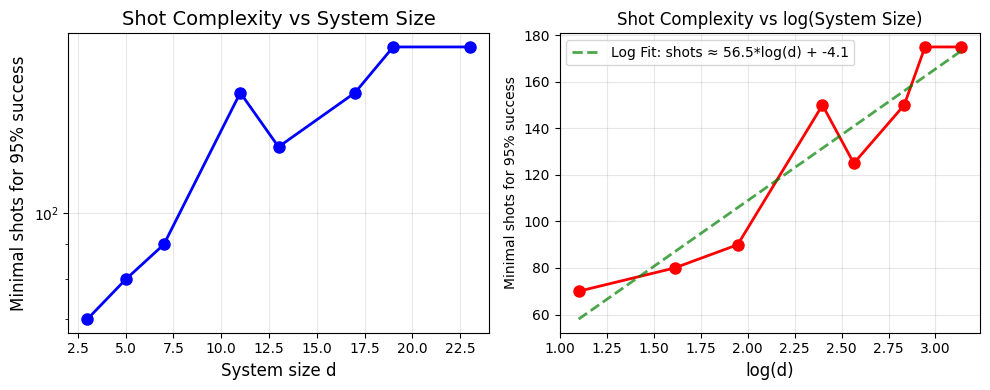


SCALING EXPERIMENT SUMMARY
d =  3:    70 shots | log(d) = 1.099
d =  5:    80 shots | log(d) = 1.609
d =  7:    90 shots | log(d) = 1.946
d = 11:   150 shots | log(d) = 2.398
d = 13:   125 shots | log(d) = 2.565
d = 17:   150 shots | log(d) = 2.833
d = 19:   175 shots | log(d) = 2.944
d = 23:   175 shots | log(d) = 3.135

System size increased by factor: 7.7
Required shots increased by factor: 2.5
Logarithmic fit: shots ≈ 56.5*log(d) + -4.1


In [ ]:
# @title 𝑑-Scaling Behavior of Conjugate Pairs (Magnitude Learning)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Quantum sensor array for photon localization in phase space
class QuantumSensorArray:
    def __init__(self, n_sensors, array_length=1.0):
        self.n_sensors = n_sensors
        self.L = array_length
        self.dim = n_sensors  # Hilbert space dimension

    # Constructs the Heisenberg-Weyl displacement operator D_{q,p} = τ^{qp} Z^p X^q
    def get_displacement_operator(self, q_idx, p_idx):
        d = self.dim
        omega = np.exp(2j * np.pi / d)
        Z = np.diag([omega ** j for j in range(d)])
        X = np.roll(np.eye(d), 1, axis=0)
        tau = np.exp(np.pi * 1j * (d + 1) / d)
        D_qp = tau ** (q_idx * p_idx) * np.linalg.matrix_power(Z, p_idx) @ np.linalg.matrix_power(X, q_idx)
        return D_qp

# Constructs Bell basis |Φ_{a,b}> (eigenbasis for D_{q,p} ⊗ D_{-q,p})
def construct_bell_basis(sensor_array):
    d = sensor_array.dim
    bell_states = []
    for a in range(d):
        for b in range(d):
            state = np.zeros(d * d, dtype=complex)
            for j in range(d):
                phase = np.exp(2j * np.pi * b * j / d)
                ket1_idx = (j + a) % d
                ket2_idx = (-j + d) % d
                final_idx = ket1_idx * d + ket2_idx
                state[final_idx] += phase
            state /= np.sqrt(d)
            bell_states.append(state)
    return np.array(bell_states).T

# Simulates measurements of rho_tensor in Bell basis
def simulate_bell_measurements(rho_tensor, d, sensor_array, n_shots=1000):
    bell_basis = construct_bell_basis(sensor_array)
    projectors = []
    for i in range(d * d):
        bell_state = bell_basis[:, i:i+1]
        projector = bell_state @ bell_state.conj().T
        projectors.append(projector)

    probs = [np.real(np.trace(p @ rho_tensor)) for p in projectors]
    probs = np.maximum(0, probs)
    probs /= np.sum(probs)

    outcomes = np.random.choice(d * d, size=n_shots, p=probs)
    a_vals = outcomes // d
    b_vals = outcomes % d
    return a_vals, b_vals

# Fourier reconstruction to get displacement map |y_{q,p}|^2
def compute_displacement_map(p_ab, d):
    v_qp = np.zeros((d, d), dtype=complex)
    a_coords = np.arange(d)
    b_coords = np.arange(d)

    for q in range(d):
        for p in range(d):
            phase_grid = np.exp(2j * np.pi * (a_coords[:, np.newaxis] * p - b_coords * q) / d)
            v_qp[q, p] = np.sum(p_ab * phase_grid)

    return np.abs(v_qp)

# Single trial: returns True if localization succeeds (finds either (q0,p0) or (-q0,-p0))
def run_single_trial(sensor_array, q_0, p_0, epsilon, n_shots):
    d = sensor_array.dim

    # Step 1: Construct signal state
    D_qp_0 = sensor_array.get_displacement_operator(q_0, p_0)
    signal_operator = 0.5 * (D_qp_0.conj().T + D_qp_0)
    rho_signal = (1/d) * (np.eye(d) + epsilon * signal_operator)

    # Step 2: Prepare tensor product for measurement
    rho_tensor = np.kron(rho_signal, np.conjugate(rho_signal))

    # Step 3: Simulate measurements
    a_vals, b_vals = simulate_bell_measurements(rho_tensor, d, sensor_array, n_shots=n_shots)

    # Step 4: Create histogram
    p_ab, _, _ = np.histogram2d(a_vals, b_vals, bins=d, range=[[0, d], [0, d]])
    if np.sum(p_ab) > 0:
        p_ab /= np.sum(p_ab)

    # Step 5: Reconstruct displacement map
    displacement_map = compute_displacement_map(p_ab, d)

    # Find peak while ignoring (0,0) artifact
    displacement_map_copy = displacement_map.copy()
    displacement_map_copy[0, 0] = 0
    q_star, p_star = np.unravel_index(np.argmax(displacement_map_copy), displacement_map.shape)

    # Check success: recovered peak matches either (q0,p0) or (-q0,-p0) mod d
    success = ((q_star == q_0 and p_star == p_0) or
               (q_star == (-q_0) % d and p_star == (-p_0) % d))

    return success

# Calculate success rate over multiple trials
def calculate_success_rate(sensor_array, q_0, p_0, epsilon, n_shots, n_trials=100):
    successes = 0
    for _ in range(n_trials):
        if run_single_trial(sensor_array, q_0, p_0, epsilon, n_shots):
            successes += 1
    return successes / n_trials

# Find minimal n_shots for given success threshold
def find_minimal_shots(sensor_array, q_0, p_0, epsilon, success_threshold=0.95,
                      n_shots_range=None, n_trials_per_test=100):
    if n_shots_range is None:
        n_shots_range = [200, 225, 250, 275, 300]

    for n_shots in n_shots_range:
        success_rate = calculate_success_rate(sensor_array, q_0, p_0, epsilon,
                                            n_shots, n_trials_per_test)
        if success_rate >= success_threshold:
            return n_shots

    return None  # Failed to find within range

# Main scaling experiment
def run_scaling_experiment(d_values, epsilon=0.9, success_threshold=0.95,
                          n_trials_per_test=10, n_shots_max=2000):
    results = {'d': [], 'minimal_shots': [], 'log_d': []}

    # Define shot number search range
    n_shots_range = list(range(10, 100, 10)) + list(range(100, 1000, 25)) + \
                   list(range(1000, n_shots_max + 1, 500))

    for d in tqdm(d_values, desc="Testing different system sizes"):
        sensor_array = QuantumSensorArray(n_sensors=d)

        # Choose test signal location (avoid edges and (0,0))
        q_0 = d // 3
        p_0 = d // 2

        minimal_shots = find_minimal_shots(sensor_array, q_0, p_0, epsilon,
                                         success_threshold, n_shots_range,
                                         n_trials_per_test)

        if minimal_shots is not None:
            results['d'].append(d)
            results['minimal_shots'].append(minimal_shots)
            results['log_d'].append(np.log(d))
            print(f"d={d}: minimal shots = {minimal_shots}")
        else:
            print(f"d={d}: FAILED to achieve {success_threshold:.0%} success rate")

    return results

# Plotting function
def plot_scaling_results(results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Plot 1: minimal_shots vs d
    ax1.plot(results['d'], results['minimal_shots'], 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('System size d', fontsize=12)
    ax1.set_ylabel('Minimal shots for 95% success', fontsize=12)
    ax1.set_title('Shot Complexity vs System Size', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')

    # Plot 2: minimal_shots vs log(d)
    ax2.plot(results['log_d'], results['minimal_shots'], 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('log(d)', fontsize=12)
    ax2.set_ylabel('Minimal shots for 95% success', fontsize=10)
    ax2.set_title('Shot Complexity vs log(System Size)', fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Add logarithmic scaling line for reference
    if len(results['log_d']) > 1:
        # Fit a linear model: shots = A * log(d) + B
        A, B = np.polyfit(results['log_d'], results['minimal_shots'], 1)
        fitted_line = A * np.array(results['log_d']) + B
        ax2.plot(results['log_d'], fitted_line, 'g--', linewidth=2, alpha=0.7,
                label=f'Log Fit: shots ≈ {A:.1f}*log(d) + {B:.1f}')
        ax2.legend()

    plt.tight_layout()
    plt.savefig('quantum_sensor_scaling.png', dpi=150)
    plt.show()

    # Print summary statistics
    print("\n" + "="*50)
    print("SCALING EXPERIMENT SUMMARY")
    print("="*50)
    for i in range(len(results['d'])):
        print(f"d = {results['d'][i]:2d}: {results['minimal_shots'][i]:5d} shots | log(d) = {results['log_d'][i]:.3f}")

    if len(results['d']) > 1:
        # Calculate growth rate
        d_growth = results['d'][-1] / results['d'][0]
        shots_growth = results['minimal_shots'][-1] / results['minimal_shots'][0]
        print(f"\nSystem size increased by factor: {d_growth:.1f}")
        print(f"Required shots increased by factor: {shots_growth:.1f}")

        # Show logarithmic fit (theory prediction: O(log d))
        A, B = np.polyfit(results['log_d'], results['minimal_shots'], 1)
        print(f"Logarithmic fit: shots ≈ {A:.1f}*log(d) + {B:.1f}")

# MAIN EXECUTION - Scaling - small
if __name__ == "__main__":
    # Test with prime numbers as suggested
    d_values = [3, 5, 7, 11, 13, 17, 19, 23]

    print("Starting quantum sensor array scaling experiment...")
    print(f"Testing system sizes: {d_values}")
    print(f"Signal strength (epsilon): 0.9")
    print(f"Success criterion: 67% (⅔) correct localization over 10 trials)")
    print(f"Success = finding either (q0,p0) or (-q0,-p0) mod d")
    print("-" * 50)

    # Run the experiment
    results = run_scaling_experiment(d_values, epsilon=0.9, success_threshold=0.66667,
                                   n_trials_per_test=10, n_shots_max=600)

    # Plot and analyze results
    if results['d']:
        plot_scaling_results(results)
    else:
        print("No successful results to plot")